# MAE Poly Loss Analysis 

In [321]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import scipy.stats as stats
import tensorflow as tf
from sklearn.metrics import fbeta_score

In [322]:
wd = os.getcwd()
data = os.path.join(wd, "data")
wd

'/Users/jakegwinn/Documents/argonne_F24/u.jw_analysis'

### Functions

In [323]:
class CustomFbetaMetric(tf.keras.metrics.Metric):
    def __init__(self, beta=1, threshold=0.4, name='custom_fbeta_score', **kwargs):
        super(CustomFbetaMetric, self).__init__(name=name, **kwargs)
        self.beta = beta
        self.threshold = threshold
        
        self.precision_metric = tf.keras.metrics.Precision()
        self.recall_metric = tf.keras.metrics.Recall()

    # def discretize(self, y_true, y_pred, sample_weight=None):
    #     # Using np.where to discretize y_pred and y_true
        
    #     return y_true, y_pred

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Use numpy function for discretization
        # y_true, y_pred = self.discretize(y_true, y_pred)
        
        y_pred_disc = tf.where(y_pred >= self.threshold, 0, 1)
        y_true_disc = tf.where(y_true >= self.threshold, 0, 1)
        # print(y_true)
        # y_pred_disc = tf.where(y_pred >= self.threshold, 1, 0)
        # y_true_disc = tf.where(y_true >= self.threshold, 1, 0)
        
        # y_pred_disc = tf.where(y_pred < self.threshold, 1, 0)
        # y_true_disc = tf.where(y_true < self.threshold, 1, 0)
        
        self.precision_metric.update_state(y_true_disc, y_pred_disc, sample_weight=sample_weight)
        self.recall_metric.update_state(y_true_disc, y_pred_disc, sample_weight=sample_weight)
        
        
        # self.precision_metric.update_state(y_true, y_pred_disc, sample_weight=sample_weight)
        # self.recall_metric.update_state(y_true, y_pred_disc, sample_weight=sample_weight)
        # Update the state using the fbeta_score metric
        # self.fbeta_score.update_state(y_true, y_pred, sample_weight=sample_weight)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        
        beta_squared = self.beta ** 2
        fbeta = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + tf.keras.backend.epsilon())
        return fbeta

    def reset_states(self):
        self.precision_metric.reset_states()
        self.recall_metric.reset_states()

In [324]:
metric = CustomFbetaMetric()

In [375]:
def mae_calc_thresh(dataframe, threshold):
    
    df = dataframe[dataframe["auc_true"] < threshold]
    y_true = df["auc_true"]
    y_pred = df["auc_pred"]
    
    residuals_below = y_true - y_pred
    
    df = dataframe[dataframe["auc_true"] >= threshold]
    y_true = df["auc_true"]
    y_pred = df["auc_pred"]
    
    residuals_above = y_true - y_pred
    
    return (np.mean(np.abs(residuals_below)), np.mean(np.abs(residuals_above)))

In [ ]:
def f_beta_wrapper(dataframe, threshold, b):
    y_true = dataframe["auc_true"]
    y_pred = dataframe["auc_pred"]
    
    # print(y_true)
    y_true = (threshold > y_true).astype(int)
    # print(y_true)
    y_pred = (threshold > y_pred).astype(int)

    return fbeta_score(y_true=y_true, y_pred=y_pred, beta=b)
    

### Plot Functions

In [326]:
def residual_plot(data, alpha):
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Residual Plot\nAlpha = {alpha}")
    
    plt.show()

In [327]:
def res_v_true(data, alpha, auc_max=1):
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    mask = (y_true <= auc_max)
    y_true_filtered = y_true[mask]
    residuals_filtered = residuals[mask]
    
    
    coefficients = np.polyfit(y_true_filtered, residuals_filtered, deg=1)
    slope, intercept = coefficients
    best_fit_line = slope * y_true_filtered + intercept
    
    # Plot the best-fit line
    plt.plot(y_true_filtered, best_fit_line, color="red", label=f"Best Fit (True ≤ {auc_max})")
    
    plt.scatter(y_true, residuals)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f"Residuals vs True Values Plot\nAlpha = {alpha}")
    plt.show()

In [328]:
def error_distrib(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title(f"Error Distribution\nAlpha = {alpha}")
    
    plt.show()

In [329]:
def error_abs_distrib(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    
    sns.histplot(np.abs(residuals), kde=True)
    plt.xlabel("Residuals")
    plt.title(f"Absolute Value Error Distribution\nAlpha = {alpha}")
    
    plt.show()

In [330]:
def qqres_plot(data, alpha):
    
    y_true = data["auc_true"]
    y_pred = data["auc_pred"]
    
    residuals = y_true - y_pred
    studentized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

    fig = sm.qqplot(studentized_residuals, line='45')
    # Customize plot
    plt.title(f"QQ Plot of Studentized Residuals\nAlpha = {alpha}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

### Ranking Functions

In [331]:
def make_rank_df(test_data):
    unique_samps = test_data["improve_sample_id"].unique()

    data_dict = {}

    for samp in unique_samps:
        true_order = test_data[test_data["improve_sample_id"] == samp].sort_values(by="auc_true", ascending = False).reset_index(drop = True)
        pred_order = true_order.sort_values(by="auc_pred", ascending = False)
        
        data_dict[samp] = {"true": true_order, "pred": pred_order}
        # break

    # print(data_dict)

    key_list = ["improve_sample_id", "spearman_all", "kendall_tau_val", "kendall_tau_pval"]
    ranking_dict = {key: [] for key in key_list}

    for key in data_dict.keys(): 
            
            rank_actual = data_dict[key]["true"]
            rank_predict = data_dict[key]["true"]
            
            sum1 = 0
        # Sum of difference squares (Σ d^2)
            sum2 = 0
            all = len(rank_actual)
            
            for i in range(0, all):
                # drug = rank_actual.iloc[i][2]
                # print("drug ", drug)
                # match = rank_predict.loc[rank_predict["improve_chem_id"] == drug]
                # print("match ", match.index.item())
                true_item = rank_actual["improve_chem_id"][i]
                # print(true_item)
                # print(rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item])
                predicted_rank = rank_predict["improve_chem_id"][rank_predict["improve_chem_id"] == true_item].index[0]

                diff  = abs(i - predicted_rank)
                
                sum1 += diff
                diff2 = diff ** 2
                # print("diff2 ", diff2)
                sum2 += diff2
                # print("match ", str(match), " is ", )
            spearman_all = 1 - 6*sum2/(all*(all**2 - 1))
            ########################################################
            ranks_true = rank_actual.index.to_list()
            ranks_pred = rank_predict.index.to_list()
            kt = stats.kendalltau(ranks_true, ranks_pred)
            #######################################################
            
            ranking_dict["improve_sample_id"].append(key)
            ranking_dict["spearman_all"].append(spearman_all)
            ranking_dict["kendall_tau_val"].append(kt[0])
            ranking_dict["kendall_tau_pval"].append(kt[1])
            
    return pd.DataFrame(ranking_dict)

## Base Case: Polynomial with degree 0 &rarr; MAE

In [332]:
folder = os.path.join(data, "basecase")
os.listdir(folder)
test_base = pd.read_csv(os.path.join(folder, "test_y_predicted_mae.csv"))

test_base.to_csv("test.tsv", sep="\t", index=False)

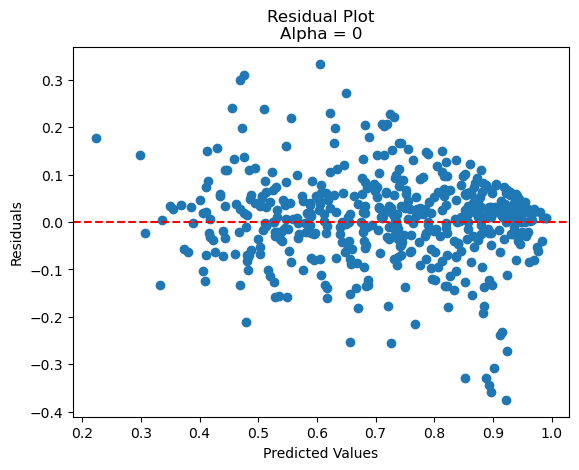

In [333]:
residual_plot(test_base, alpha=0)

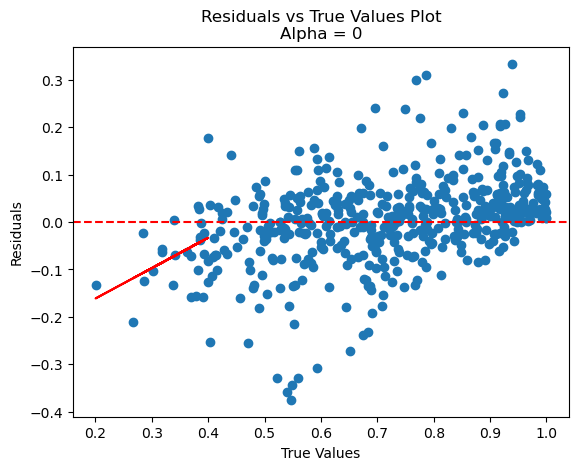

In [334]:
res_v_true(test_base, alpha=0, auc_max=0.4)

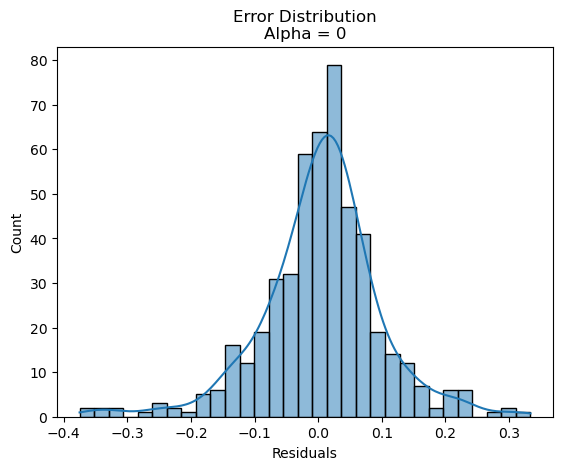

In [335]:
error_distrib(test_base, alpha=0)

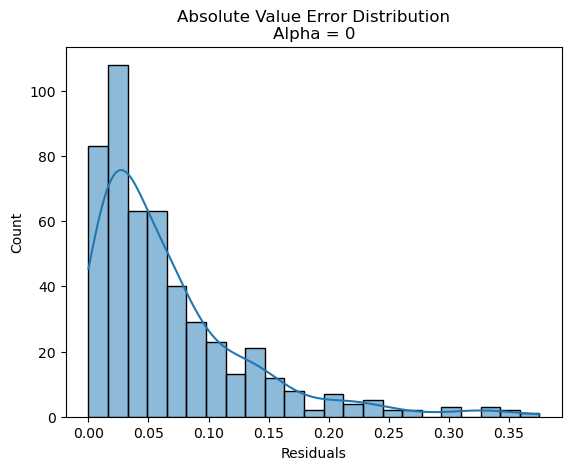

In [336]:
error_abs_distrib(test_base, alpha=0)

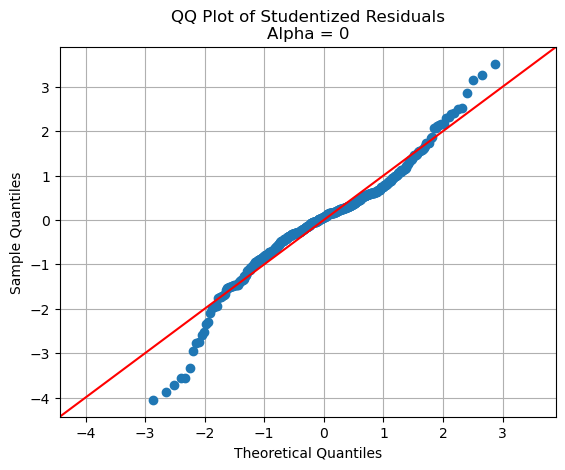

In [337]:
qqres_plot(test_base, alpha=0)

In [338]:
make_rank_df(test_base)


/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


In [369]:
f_beta_wrapper(test_base, 0.5, 4)

0      0.9700
1      0.9061
2      0.9846
3      0.9246
4      0.9222
        ...  
489    0.6032
490    0.5981
491    0.6009
492    0.5345
493    0.5827
Name: auc_true, Length: 494, dtype: float64
0      0
1      0
2      0
3      0
4      0
      ..
489    0
490    0
491    0
492    0
493    0
Name: auc_true, Length: 494, dtype: int64


0.689594356261023

## Polynomial with Degree 2

In [340]:
folder = os.path.join(data, "maep2")
os.listdir(folder)
test_p2 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_maep2.csv"))
test_p2

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.8857
1,ACH-000219,Drug_1163,0.9061,0.9061,0.8580
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9050
3,ACH-000548,Drug_1163,0.9246,0.9246,0.8772
4,ACH-000288,Drug_1163,0.9222,0.9222,0.8750
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6236
490,ACH-000704,Drug_1127,0.5981,0.5981,0.5011
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6299
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5410


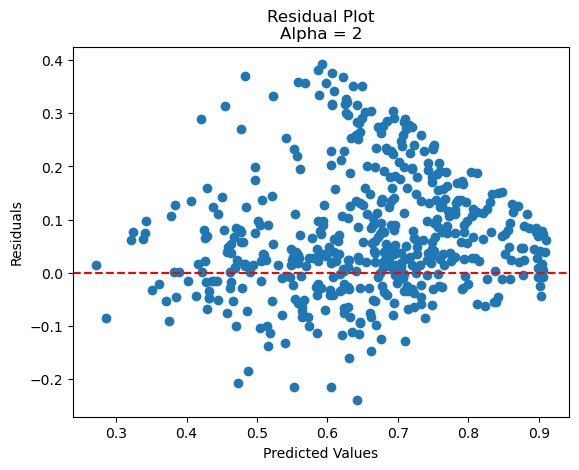

In [341]:
residual_plot(test_p2, alpha=2)

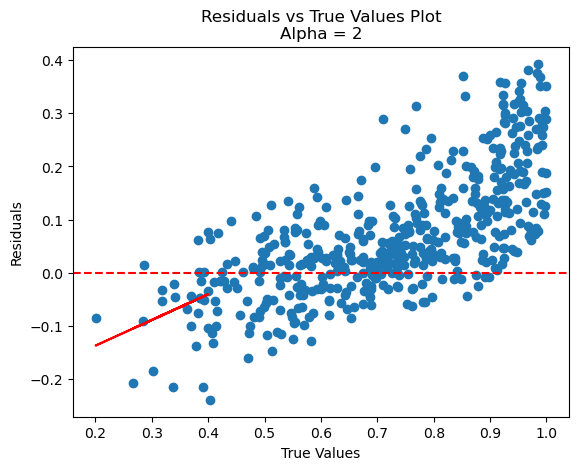

In [342]:
res_v_true(test_p2, alpha=2, auc_max=0.4)

Line of best fit with lower values to see if push up

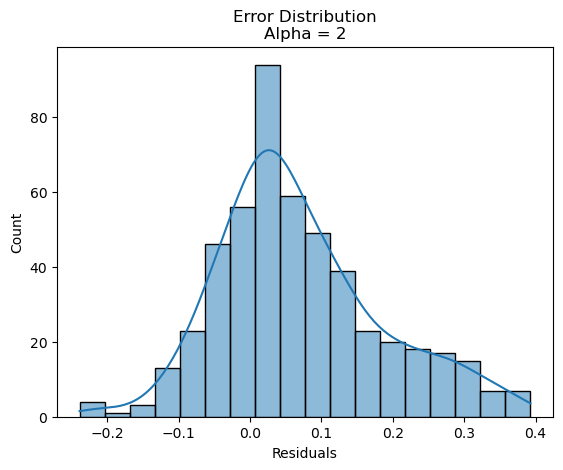

In [343]:
error_distrib(test_p2, alpha=2)

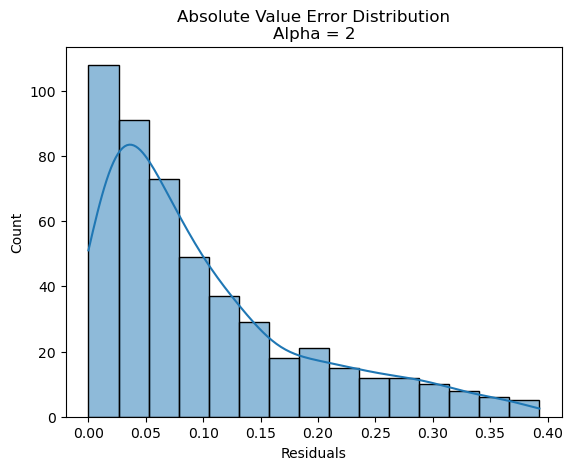

In [344]:
error_abs_distrib(test_p2, alpha=2)

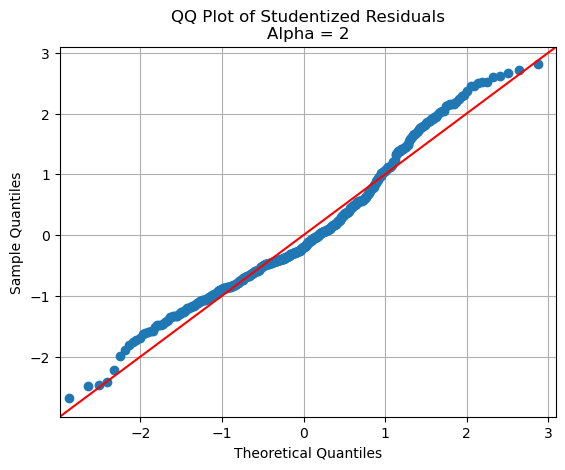

In [345]:
qqres_plot(test_p2, alpha=2)

In [346]:
df = test_p2[test_p2["auc_true"] < 0.4]
y_true = df["auc_true"]
y_pred = df["auc_pred"]
    
residuals = y_true - y_pred
np.mean(np.abs(residuals))

0.07703333333333333

In [370]:
f_beta_wrapper(test_p2, 0.5, 4)

0      0.9700
1      0.9061
2      0.9846
3      0.9246
4      0.9222
        ...  
489    0.6032
490    0.5981
491    0.6009
492    0.5345
493    0.5827
Name: auc_true, Length: 494, dtype: float64
0      0
1      0
2      0
3      0
4      0
      ..
489    0
490    0
491    0
492    0
493    0
Name: auc_true, Length: 494, dtype: int64


0.7262423714036618

In [348]:
make_rank_df(test_p2)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


## Polynomial with Degree 4

In [349]:
folder = os.path.join(data, "maep4")
os.listdir(folder)
test_p4 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_maep4.csv"))
test_p4

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.5651
1,ACH-000219,Drug_1163,0.9061,0.9061,0.4688
2,ACH-000222,Drug_1163,0.9846,0.9846,0.6355
3,ACH-000548,Drug_1163,0.9246,0.9246,0.5474
4,ACH-000288,Drug_1163,0.9222,0.9222,0.5184
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.5652
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4362
491,ACH-000042,Drug_1127,0.6009,0.6009,0.4850
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5168


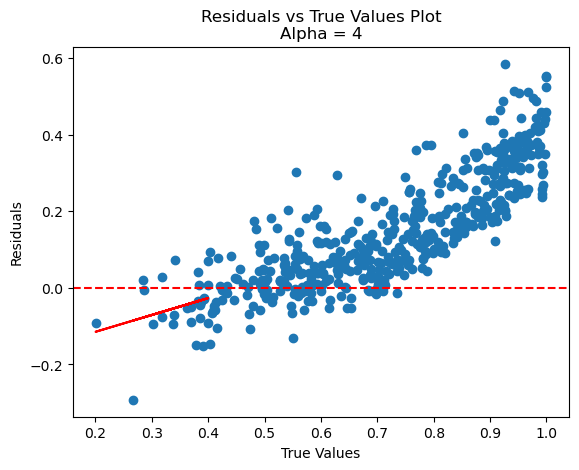

In [350]:
res_v_true(test_p4, alpha=4, auc_max=0.4)

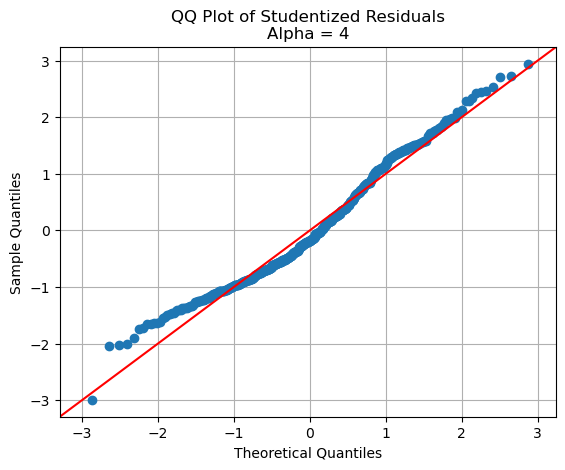

In [351]:
qqres_plot(test_p4, alpha=4)

- zero inflated models --> logistic regression 
- log odds transformation 
    - Data transformation
- 

In [352]:
make_rank_df(test_p4)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


In [371]:
f_beta_wrapper(test_p4, 0.5, 4)

0      0.9700
1      0.9061
2      0.9846
3      0.9246
4      0.9222
        ...  
489    0.6032
490    0.5981
491    0.6009
492    0.5345
493    0.5827
Name: auc_true, Length: 494, dtype: float64
0      0
1      0
2      0
3      0
4      0
      ..
489    0
490    0
491    0
492    0
493    0
Name: auc_true, Length: 494, dtype: int64


0.8163437236731256

## Huber Loss

In [354]:
# data
# folder = os.path.join(data, "huber")
# os.listdir(folder)
# test_hube = pd.read_csv(os.path.join(folder, "test_y_data_predicted_hube.csv"))
# test_hube

# resid_hube = test_hube["auc_true"] - test_hube["auc_pred"]
# resid_p2 = test_p2["auc_true"] - test_p2["auc_pred"]

# resid_hube == resid_p2

In [355]:
# residual_plot(test_hube, "NA")

In [356]:
# res_v_true(test_hube, "NA")

In [357]:
# qqres_plot(test_hube, "NA")

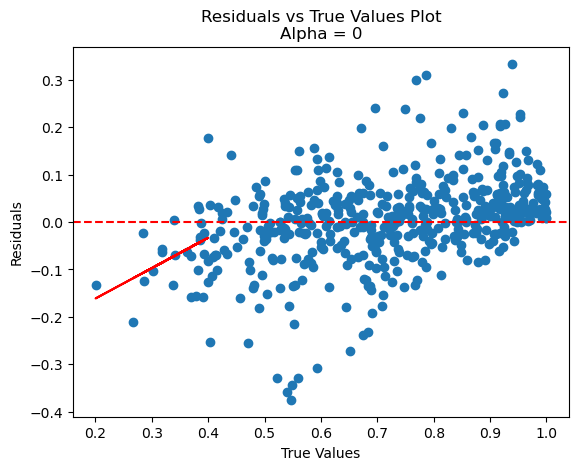

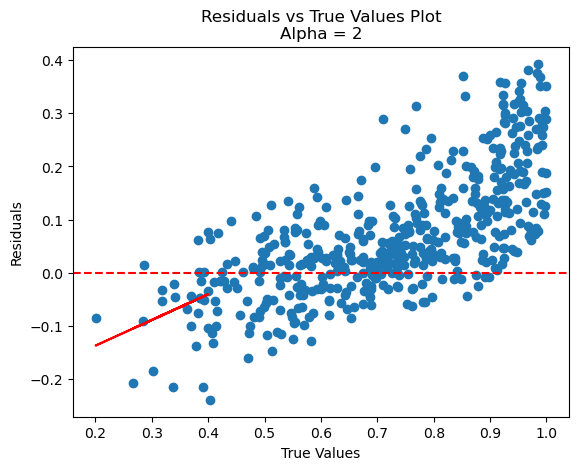

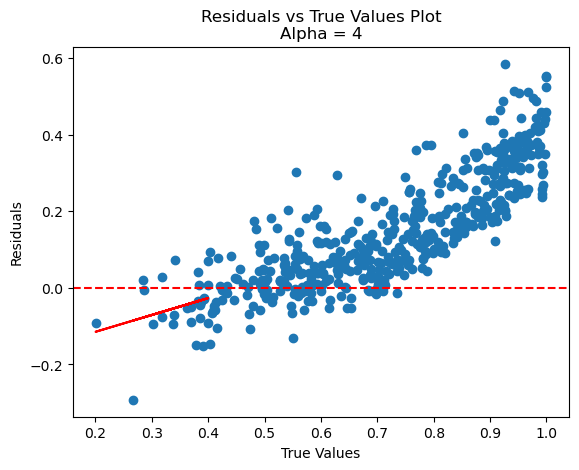

In [358]:
res_v_true(test_base, alpha=0, auc_max=0.4)
res_v_true(test_p2, alpha=2, auc_max=0.4)
res_v_true(test_p4, alpha=4, auc_max=0.4)

## Exponential Loss

In [359]:
folder = os.path.join(data, "exp4")
os.listdir(folder)
test_e4 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_exp4.csv"))
test_e4

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.9492
1,ACH-000219,Drug_1163,0.9061,0.9061,0.9569
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9496
3,ACH-000548,Drug_1163,0.9246,0.9246,0.9449
4,ACH-000288,Drug_1163,0.9222,0.9222,0.9623
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6554
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4544
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6411
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5311


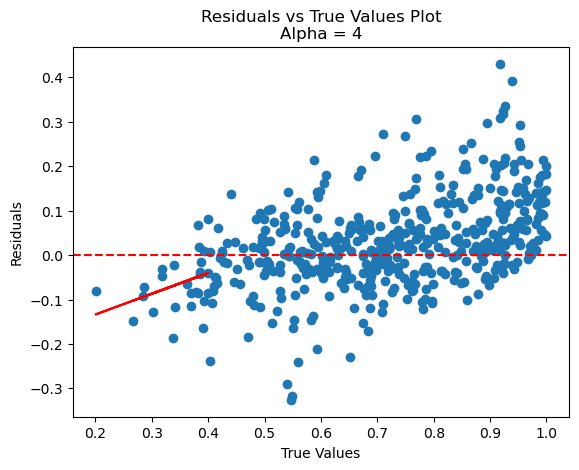

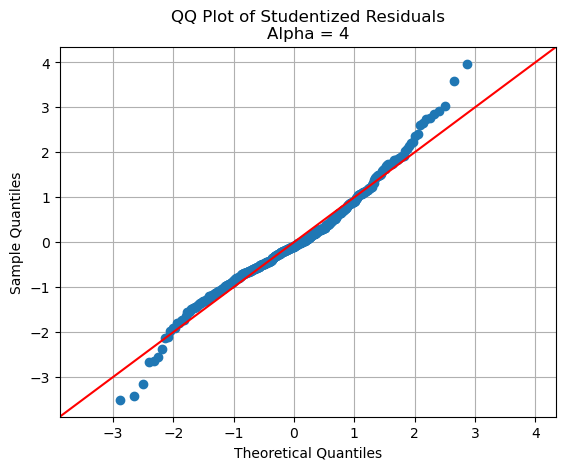

In [360]:
res_v_true(test_e4, 4, auc_max=0.4)
qqres_plot(test_e4, 4)

In [361]:
make_rank_df(test_e4)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


## Exponential 7

In [362]:
folder = os.path.join(data, "exp7")
os.listdir(folder)
test_e7 = pd.read_csv(os.path.join(folder, "test_y_data_predicted_exp7.csv"))
test_e7

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.9408
1,ACH-000219,Drug_1163,0.9061,0.9061,0.9081
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9532
3,ACH-000548,Drug_1163,0.9246,0.9246,0.9279
4,ACH-000288,Drug_1163,0.9222,0.9222,0.9201
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6373
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4020
491,ACH-000042,Drug_1127,0.6009,0.6009,0.5259
492,ACH-000677,Drug_1127,0.5345,0.5345,0.4723


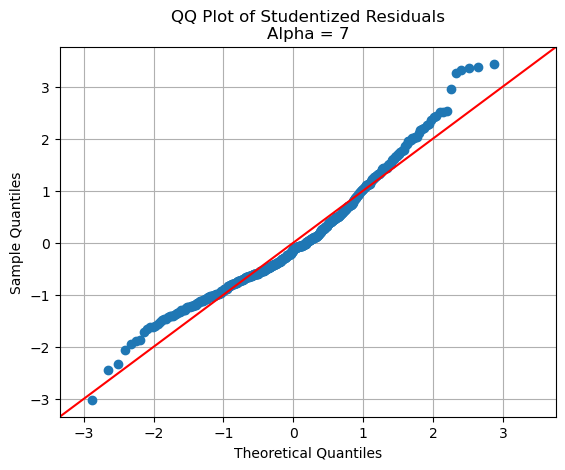

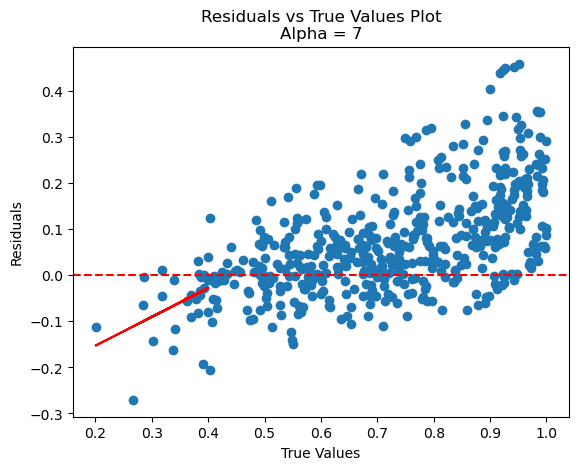

In [363]:
qqres_plot(test_e7, 7)
res_v_true(test_e7, 7, auc_max=0.4)

In [364]:
make_rank_df(test_e7)

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_16915/3505800086.py:45: RuntimeWarning: invalid value encountered in scalar divide
  spearman_all = 1 - 6*sum2/(all*(all**2 - 1))


,improve_sample_id,spearman_all,kendall_tau_val,kendall_tau_pval
0,ACH-000948,1.0,1.0,0.083333
1,ACH-000219,NaN,NaN,NaN
2,ACH-000222,1.0,1.0,0.016667
3,ACH-000548,1.0,1.0,1.000000
4,ACH-000288,1.0,1.0,0.002778
...,...,...,...,...
253,ACH-000738,NaN,NaN,NaN
254,ACH-000861,NaN,NaN,NaN
255,ACH-000648,NaN,NaN,NaN
256,ACH-000638,NaN,NaN,NaN


In [377]:
print(mae_calc_thresh(test_base, 0.5))
print(mae_calc_thresh(test_p2, 0.5))
print(mae_calc_thresh(test_p4, 0.5))
print(mae_calc_thresh(test_e4, 0.5))
print(mae_calc_thresh(test_e7, 0.5))


(0.07708059701492537, 0.06541967213114754)
(0.0649, 0.10456978922716627)
(0.05889850746268656, 0.1802648711943794)
(0.06444328358208956, 0.0796096018735363)
(0.053726865671641796, 0.1044559718969555)


## Log Cosh

In [378]:
folder = os.path.join(data, "logcosh")
os.listdir(folder)
test_lc = pd.read_csv(os.path.join(folder, "test_y_data_predicted_cosh.csv"))
test_lc

,improve_sample_id,improve_chem_id,auc,auc_true,auc_pred
0,ACH-000948,Drug_1163,0.9700,0.9700,0.9366
1,ACH-000219,Drug_1163,0.9061,0.9061,0.9093
2,ACH-000222,Drug_1163,0.9846,0.9846,0.9326
3,ACH-000548,Drug_1163,0.9246,0.9246,0.9323
4,ACH-000288,Drug_1163,0.9222,0.9222,0.9586
...,...,...,...,...,...
489,ACH-000638,Drug_1127,0.6032,0.6032,0.6100
490,ACH-000704,Drug_1127,0.5981,0.5981,0.4962
491,ACH-000042,Drug_1127,0.6009,0.6009,0.6261
492,ACH-000677,Drug_1127,0.5345,0.5345,0.5471


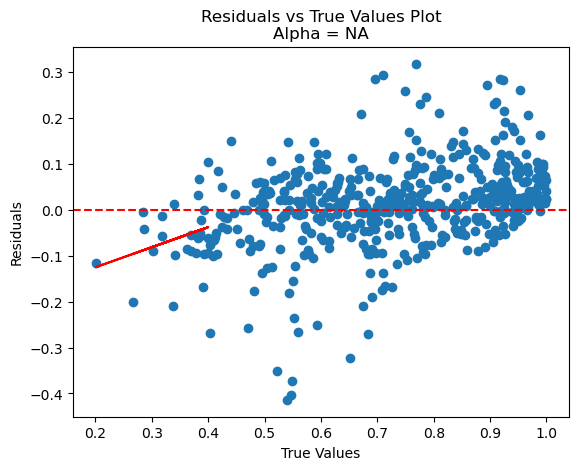

In [379]:
res_v_true(test_lc, "NA", 0.4)

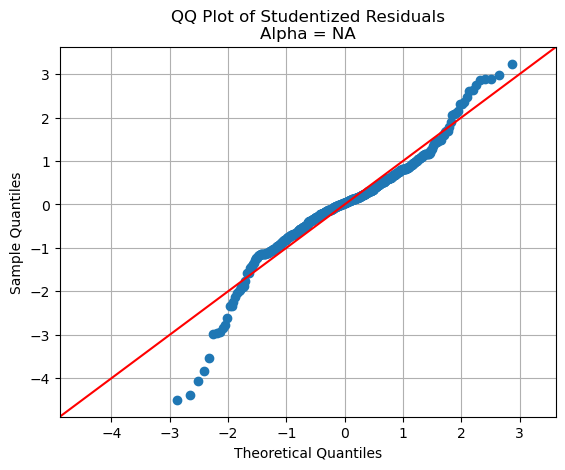

In [380]:
qqres_plot(test_lc, "NA")

In [381]:
print(mae_calc_thresh(test_lc, 0.5))


(0.06874029850746269, 0.06728009367681499)


In [382]:
f_beta_wrapper(test_lc, 0.5, 4)

0      0.9700
1      0.9061
2      0.9846
3      0.9246
4      0.9222
        ...  
489    0.6032
490    0.5981
491    0.6009
492    0.5345
493    0.5827
Name: auc_true, Length: 494, dtype: float64
0      0
1      0
2      0
3      0
4      0
      ..
489    0
490    0
491    0
492    0
493    0
Name: auc_true, Length: 494, dtype: int64


0.7673611111111112